In [1]:
#Importing the relevant packages
import pandas as pd
import numpy as np

# Libraries for Recommendation System
from scipy.sparse import csr_matrix
from sklearn.neighbors import NearestNeighbors

import warnings
warnings.filterwarnings('ignore')

from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [2]:
#Loading the relevant Datasets
books = pd.read_csv('/content/gdrive/MyDrive/books.csv', encoding='utf-8-sig')
ratings = pd.read_csv('/content/gdrive/MyDrive/ratings.csv', encoding='utf-8-sig')
to_read = pd.read_csv('/content/gdrive/MyDrive/to_read.csv', encoding='utf-8-sig')

In [3]:
books.shape

(10000, 23)

In [4]:
books.head()

,id,book_id,best_book_id,work_id,books_count,isbn,isbn13,authors,original_publication_year,original_title,title,language_code,average_rating,ratings_count,work_ratings_count,work_text_reviews_count,ratings_1,ratings_2,ratings_3,ratings_4,ratings_5,image_url,small_image_url
0,1,2767052,2767052,2792775,272,439023483,9.780439e+12,Suzanne Collins,2008.0,The Hunger Games,"The Hunger Games (The Hunger Games, #1)",eng,4.34,4780653,4942365,155254,66715,127936,560092,1481305,2706317,https://images.gr-assets.com/books/1447303603m...,https://images.gr-assets.com/books/1447303603s...
1,2,3,3,4640799,491,439554934,9.780440e+12,"J.K. Rowling, Mary GrandPré",1997.0,Harry Potter and the Philosopher's Stone,Harry Potter and the Sorcerer's Stone (Harry P...,eng,4.44,4602479,4800065,75867,75504,101676,455024,1156318,3011543,https://images.gr-assets.com/books/1474154022m...,https://images.gr-assets.com/books/1474154022s...
2,3,41865,41865,3212258,226,316015849,9.780316e+12,Stephenie Meyer,2005.0,Twilight,"Twilight (Twilight, #1)",en-US,3.57,3866839,3916824,95009,456191,436802,793319,875073,1355439,https://images.gr-assets.com/books/1361039443m...,https://images.gr-assets.com/books/1361039443s...
3,4,2657,2657,3275794,487,61120081,9.780061e+12,Harper Lee,1960.0,To Kill a Mockingbird,To Kill a Mockingbird,eng,4.25,3198671,3340896,72586,60427,117415,446835,1001952,1714267,https://images.gr-assets.com/books/1361975680m...,https://images.gr-assets.com/books/1361975680s...
4,5,4671,4671,245494,1356,743273567,9.780743e+12,F. Scott Fitzgerald,1925.0,The Great Gatsby,The Great Gatsby,eng,3.89,2683664,2773745,51992,86236,197621,606158,936012,947718,https://images.gr-assets.com/books/1490528560m...,https://images.gr-assets.com/books/1490528560s...


In [5]:
ratings.shape

(981756, 3)

In [6]:
ratings.head()

,book_id,user_id,rating
0,1,314,5
1,1,439,3
2,1,588,5
3,1,1169,4
4,1,1185,4


In [7]:
books = books[['id','title']]
books.rename(columns = {'id':'book_id'}, inplace = True) 

In [8]:
books.head()

,book_id,title
0,1,"The Hunger Games (The Hunger Games, #1)"
1,2,Harry Potter and the Sorcerer's Stone (Harry P...
2,3,"Twilight (Twilight, #1)"
3,4,To Kill a Mockingbird
4,5,The Great Gatsby


In [9]:
#Removing the subtitle-title inside brackets from the 'title' column
books['title'] = books.title.str.replace(r"\(.*\)",'')

In [10]:
#Remove white space at the end of string
books.title = books.title.str.rstrip()

In [11]:
books = books.loc[:,{"book_id","title"}]
ratings = ratings.loc[:,{"user_id","book_id","rating"}]

In [12]:
ratings.shape

(981756, 3)

In [13]:
#Removing duplicate records
ratings = ratings.drop_duplicates(subset=['book_id', 'user_id'], keep='last')

In [14]:
ratings.shape

(979478, 3)

In [15]:
#Getting unique users count
number_of_users = ratings['user_id'].unique()
len(number_of_users)

53424

In [16]:
count = ratings['user_id'].value_counts()
ratings = ratings[ratings['user_id'].isin(count[count >= 20].index)]
ratings.shape

(720212, 3)

In [17]:
#Getting unique users count
number_of_users = ratings['user_id'].unique()
len(number_of_users)

14612

In [18]:
#Getting unique books count
number_of_books = ratings['book_id'].unique()
len(number_of_books)

9999

In [19]:
data = pd.DataFrame()
data = pd.merge(books,ratings)

In [20]:
data = data.sort_values('user_id').reset_index(drop=True)
data

,book_id,title,rating,user_id
0,6444,"Death Note, Vol. 2: Confluence",4,7
1,2693,A Fire Upon the Deep,4,7
2,2325,The Player of Games,4,7
3,1801,The Sword of Shannara,5,7
4,6701,Red Prophet,3,7
...,...,...,...,...
720207,4819,Airhead,4,53413
720208,4195,The Guard,4,53413
720209,3704,The Bane Chronicles,4,53413
720210,6497,A Dance with Dragons: After the Feast,3,53413


In [21]:
data = data.iloc[:800000,:]
user_book_table = data.pivot_table(index =["user_id"],columns =['book_id'],values ="rating").fillna(0)
user_book_table.head(5)

book_id,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,...,9961,9962,9963,9964,9965,9966,9967,9968,9969,9970,9971,9972,9973,9974,9975,9976,9977,9978,9979,9980,9981,9982,9983,9984,9985,9986,9987,9988,9989,9990,9991,9992,9993,9994,9995,9996,9997,9998,9999,10000
user_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
19,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
23,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
27,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
35,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [22]:
#Get nearest users to the inserted user info
def get_kneighbors(user_id):
    
    user_book_table_matrix = csr_matrix(user_book_table.values)
    model_knn = NearestNeighbors(metric = 'cosine', algorithm = 'brute')
    model_knn.fit(user_book_table_matrix)
    distances, indices = model_knn.kneighbors(user_book_table.iloc[user_id-1,:].values.reshape(1,-1), n_neighbors = 50)

    user = []
    distance = []

    for i in range(0, len(distances.flatten())):
        if i != 0:
            user.append(user_book_table.index[indices.flatten()[i]])
            distance.append(distances.flatten()[i])    

    m=pd.Series(user,name='user_id')
    d=pd.Series(distance,name='distance_value')
    top_users = pd.concat([m,d], axis=1)
    top_users = top_users.sort_values('distance_value')

    top_users = pd.DataFrame(top_users)

    return top_users

In [23]:
#Let's get weighted rating for recommendation dataframe
def get_recommendation_df(top_users):

  #Getting the book and rating of top users
  top_users_rating = top_users.merge(ratings, left_on='user_id', right_on='user_id', how='inner')

  for index, row in top_users_rating.iterrows():
    value = 0
    if(row['rating'] == 5):
      value = row['distance_value']*1
    elif(row['rating'] == 4):
      value = row['distance_value']*2
    elif(row['rating'] == 3):
      value = row['distance_value']*3
    elif(row['rating'] == 2):
      value = row['distance_value']*4
    elif(row['rating'] == 1):
      value = row['distance_value']*5
    top_users_rating.at[index,'weighted_rating'] = value

  #Getting the sum of distance value and weighted rating by book id
  top_users_rating = top_users_rating.groupby('book_id').sum()[['distance_value','weighted_rating']]
  top_users_rating.columns = ['sum_distance_value','sum_weighted_rating']

  recommendation_df = pd.DataFrame()
  #Now we take the weighted average by book id
  recommendation_df['weighted_average_score'] = top_users_rating['sum_weighted_rating']/top_users_rating['sum_distance_value']
  recommendation_df['book_id'] = top_users_rating.index

  #Ordering the book by weighted average score
  recommendation_df = recommendation_df[recommendation_df['weighted_average_score'] <= 2.5]
  recommendation_df = recommendation_df.sort_values(by='weighted_average_score', ascending=False).reset_index(drop=True)

  return recommendation_df

In [24]:
def get_recommend_books(user_id):
    
    kneighbors = get_kneighbors(user_id)
    recommendation = get_recommendation_df(kneighbors)

    #Finally recommended books for the inputted user
    recommend_books = books.loc[books['book_id'].isin(recommendation['book_id'].tolist())]
    recommend_books = pd.merge(recommend_books, recommendation, on='book_id', how='inner')
    recommend_books = recommend_books.sort_values(by='weighted_average_score').reset_index(drop=True)
    
    #print("\n Recommended Books(",num,"):")
    #print("\n Recommended Books:")
    return recommend_books

Evaluate Accuracy

In [25]:
#Evaluate the recommended books of the particular user
def rec_accuracy(user_id):
    to_read_df = pd.DataFrame()
    #Get list of really recommended books from dataframe
    to_read_df = to_read[to_read['user_id'] == user_id]
    #Get length of really recommended books from dataframe
    to_read_len = len(to_read_df)
    
    #Get accuracy
    if to_read_len == 0:
        rec_book_len = 0
    else:
        #Get recommended books using pearson correlation
        rec_books = get_recommend_books(user_id)
        #Compare both lists of recommended books and get the number of matching books
        rec_book_len = len(rec_books.loc[rec_books['book_id'].isin(to_read_df['book_id'].tolist())].reset_index(drop=True))
        if rec_book_len == 0:
            to_read_len = 0
    
    #Calculat accuracy
    accuracy = 0
    if to_read_len == 0:
        accuracy = 0
    else:
        accuracy = rec_book_len/to_read_len
    
    return accuracy

In [26]:
#Get recommended books for the particular user
rec_books = get_recommend_books(314)
rec_books.head()

,book_id,title,weighted_average_score
0,9969,Gut: The Inside Story of Our Body’s Most Under...,1.0
1,7305,The War that Saved My Life,1.0
2,7228,In the Shadow of the Banyan,1.0
3,1715,Let the Right One In,1.0
4,1784,The Raven,1.0


In [27]:
#Get accuracy of recommended books for the particular user
rec_accuracy(314)

0

In [28]:
%matplotlib inline
import matplotlib.pyplot as plt

x1 = []
y1 = []
y2 = []
#Evaluate the recommended books with list of user
def total_accuracy(number_of_users):
    total_read_len = 0
    total_book_len = 0
    #Passing range of user inside loop
    for i in range(number_of_users):
        to_read_df = pd.DataFrame()
        #Get list of really recommended books from dataframe
        to_read_df = to_read[to_read['user_id'] == (i+1)]
        #Get length of really recommended books from dataframe
        to_read_len = len(to_read_df)

        if to_read_len == 0:
            rec_book_len = 0
        else:
            #Get recommended books using pearson correlation
            rec_books = get_recommend_books(i+1)
            #Compare both lists of recommended books and get the number of matching books
            rec_book_len = len(rec_books.loc[rec_books['book_id'].isin(to_read_df['book_id'].tolist())].reset_index(drop=True))
            if rec_book_len == 0:
                to_read_len = 0
        
        #Add together the number of books recommended by Pearson Correlation
        total_book_len = total_book_len + rec_book_len
        #Add together the number of books recommended by to_read dataframe
        total_read_len = total_read_len + to_read_len

        y1.append(to_read_len)
        y2.append(rec_book_len)
        x1.append(i+1)  
    
    #Calculate the overall accuracy
    accuracy = total_book_len / total_read_len
    
    print("\n Total Recommended Books by DF: ",total_read_len)
    print("\n Total Recommended Books CF: ",total_book_len)
    
    return accuracy

In [29]:
%time total_accuracy(100)


 Total Recommended Books by DF:  652

 Total Recommended Books CF:  117
CPU times: user 3min 9s, sys: 258 ms, total: 3min 9s
Wall time: 3min 9s


0.1794478527607362

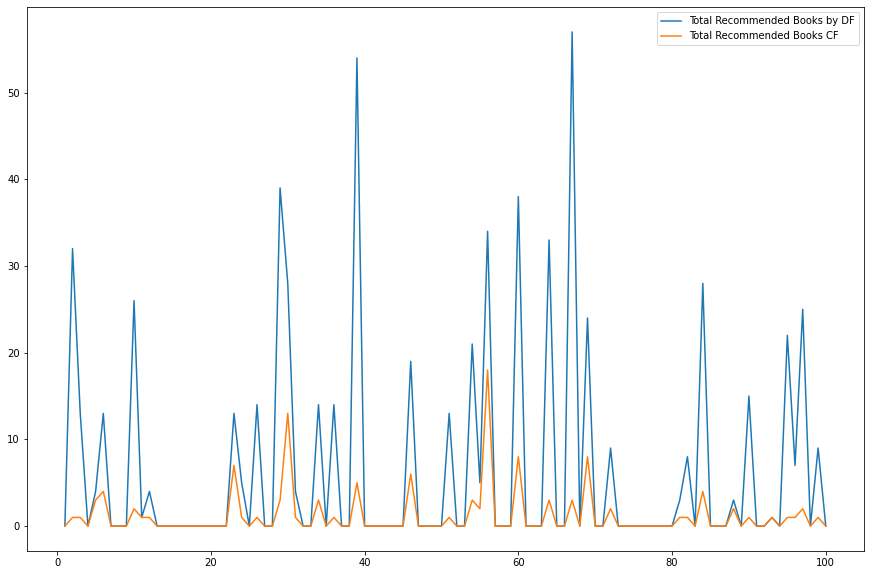

In [30]:
plt.figure(figsize=(15, 10))
plt.plot(x1, y1)
plt.plot(x1, y2)
plt.legend(["Total Recommended Books by DF", "Total Recommended Books CF"])
plt.show()